In [62]:
import numpy as np
import scipy.ndimage
plt.style.use("default")
import time

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

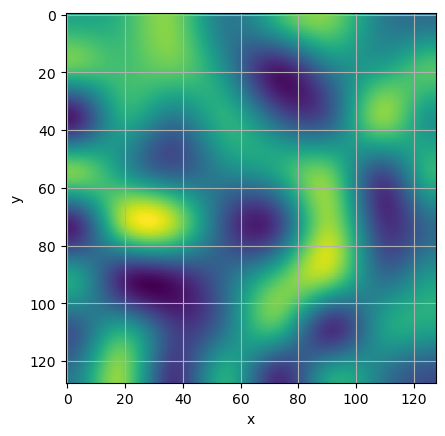

In [63]:
features = 8
zoom = 16
heatmap = np.random.random((features,features))-0.5
large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

N=features*zoom

## Generating the brush

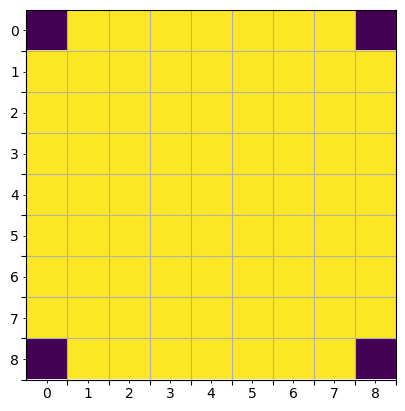

In [64]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0
brush = brush.astype(bool)

nx, ny = brush.shape

plt.imshow(brush)
ax = plt.gca()
ax.set_yticks(np.arange(nx)+0.5)
ax.set_yticklabels(["" for i in range(nx)])
ax.set_xticks(np.arange(ny)+0.5)
ax.set_xticklabels(["" for i in range(ny)])
ax.set_yticks(np.arange(nx), minor=True)
ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
ax.set_xticks(np.arange(ny), minor=True)
ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
plt.grid()

## Running the Generator

In [79]:
def dilate(img, brush):
    global time_dilate
    time_dilate -= time.process_time() 
    dil = scipy.ndimage.binary_dilation(img, brush)
    time_dilate += time.process_time() 
    return dil

def existing_pixels(touches, brush):
    return dilate(touches, brush)

def impossible_touches(existing_other, brush):
    return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush):
    possible_touches = np.logical_or(touches, valid)
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush):
    return np.logical_and(dilate(required, brush), valid)

def free_touches(possible_other, existing_other, valid, brush):
    dilated = dilate(np.logical_or(possible_other, existing_other), brush)
    return np.logical_and(np.logical_not(dilated), valid)


def select_single(s_valid, v_valid, s_suggest, v_suggest, brush, t_s, t_v, p_s_existing, p_v_existing):
    s_weights = scipy.ndimage.convolve(s_suggest, brush) # TODO eliminate this convolution!
    v_weights = -scipy.ndimage.convolve(v_suggest, brush)

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
      touch(max_pos_s, t_s, p_s_existing)
    else:
      touch(max_pos_v, t_v, p_v_existing)

def touch(flat_index, touches, existing):
  """Perform a touch on the given index of the flattened map"""
  touches.flat[flat_index] = True
  track(existing, flat_index)

def track(existing, pos):
  l = len(brush)//2
  idx = np.unravel_index(pos, existing.shape)

  # slightly complicated :/
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_existing - idx_i, 0)) for (idx_i, l_existing) in zip(idx, existing.shape)]
  existing[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]] |= brush[
        l -dw[0]:l     +up[0],
        l -dw[1]:l     +up[1],
    ]

debug = True
def log(*args):
  if debug:
    print(*args)

opt_track_existing = True

def generate():
  time_update = 0
  time_select = 0 
  global time_dilate
  time_dilate = 0
  time_existing = 0
  time_impossible = 0
  time_valid = 0
  time_possible = 0
  time_required = 0
  time_resolving = 0
  time_free = 0

  s_suggest = large_heatmap.copy()
  v_suggest = large_heatmap.copy()


  t_s = np.zeros_like(s_suggest).astype(bool)
  t_v = t_s.copy()
  p_s_existing = t_s.copy()
  p_v_existing = t_s.copy()

  for i in range(N**2):
      time_update -= time.process_time() 

      if not opt_track_existing:
        time_existing -= time.process_time() 
        p_s_existing = existing_pixels(t_s, brush)
        p_v_existing = existing_pixels(t_v, brush)
        time_existing += time.process_time() 

      s_suggest[p_s_existing] = 0
      v_suggest[p_v_existing] = 0

      time_impossible -= time.process_time() 
      t_s_impossible = impossible_touches(p_v_existing, brush)
      t_v_impossible = impossible_touches(p_s_existing, brush)
      time_impossible += time.process_time() 

      time_valid -= time.process_time() 
      t_s_valid = valid_touches(t_s_impossible, t_s)
      t_v_valid = valid_touches(t_v_impossible, t_v)
      time_valid += time.process_time() 

      time_possible -= time.process_time() 
      p_s_possible = possible_pixels(t_s_valid,t_s,brush)
      p_v_possible = possible_pixels(t_v_valid,t_v,brush)
      time_possible += time.process_time() 

      time_required -= time.process_time() 
      p_s_required = required_pixels(p_s_existing, p_v_possible)
      p_v_required = required_pixels(p_v_existing, p_s_possible)
      time_required += time.process_time() 

      time_resolving -= time.process_time() 
      t_s_resolving = resolving_touches(p_s_required, t_s_valid, brush)
      t_v_resolving = resolving_touches(p_v_required, t_v_valid, brush)
      time_resolving += time.process_time() 

      time_free -= time.process_time() 
      t_s_free = free_touches(p_v_possible, p_v_existing, t_s_valid, brush)
      t_v_free = free_touches(p_s_possible, p_s_existing, t_v_valid, brush)
      time_free += time.process_time() 

      time_update += time.process_time() 
      time_select -= time.process_time() 

      if t_s_free.any() or t_v_free.any():
          log(f"{i}: free: {t_s_free.sum()}; {t_v_free.sum()}")

          flat_free_s = np.where(t_s_free.flatten())[0]
          flat_free_v = np.where(t_v_free.flatten())[0]
          
          for idx in flat_free_s:
            touch(idx, t_s, p_s_existing)
          
          for idx in flat_free_v:
            touch(idx, t_v, p_v_existing)

      elif t_s_resolving.any() or t_v_resolving.any():
          log(f"{i}: resolving")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_resolving, t_v_resolving, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing)
      elif t_s_valid.any() or t_v_valid.any():
          log(f"{i}: valid")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_valid, t_v_valid, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing)
      else:
          print("finished")
          time_select += time.process_time() 
          break

      time_select += time.process_time() 

  plt.figure(figsize = (6,9))
  plt.subplot(221)
  plt.title("Solid and Void")
  plt.imshow(p_s_existing)
  plt.subplot(222)
  plt.title("Solid and Void Touches")
  plt.imshow(t_s.astype(int)-t_v)
  plt.subplot(223)
  plt.imshow(large_heatmap)

  return dict(
    update = time_update,
    select = time_select,
    dilate = time_dilate,
    existing = time_existing,
    impossible = time_impossible,
    valid = time_valid,
    possible = time_possible,
    required = time_required,
    resolving = time_resolving,
    free = time_free
  )

0: valid
1: valid
2: valid
3: valid
4: resolving
5: free: 0; 16
[]
[12320 12449 12450 12451 12452 12453 12454 12455 12577 12578 12579 12705
 12706 12833 12961 13089]
6: valid
7: resolving
8: free: 0; 20
[]
[11423 11551 11678 11679 11805 11806 11807 11927 11928 11929 11930 11931
 11932 11933 11934 11935 12062 12063 12192 12321]
9: valid
10: valid
11: valid
12: valid
13: valid
14: resolving
15: free: 0; 21
[]
[3276 3404 3532 3660 3661 3788 3789 3790 3916 3917 3918 3919 3920 3921
 3922 3923 4044 4045 4046 4172 4173]
16: valid
17: valid
18: free: 0; 41
[]
[12580 12581 12582 12583 12584 12707 12708 12709 12710 12711 12712 12834
 12835 12836 12837 12838 12839 12840 12962 12963 12964 12965 12966 12967
 12968 13090 13091 13092 13093 13094 13095 13096 13218 13219 13220 13221
 13222 13223 13224 13352 13481]
19: valid
20: resolving
21: free: 0; 31
[]
[2252 2253 2379 2380 2381 2501 2502 2503 2504 2505 2506 2507 2508 2509
 2634 2635 2636 2637 2763 2764 2765 2892 2893 3020 3021 3149 3277 3405
 3533 

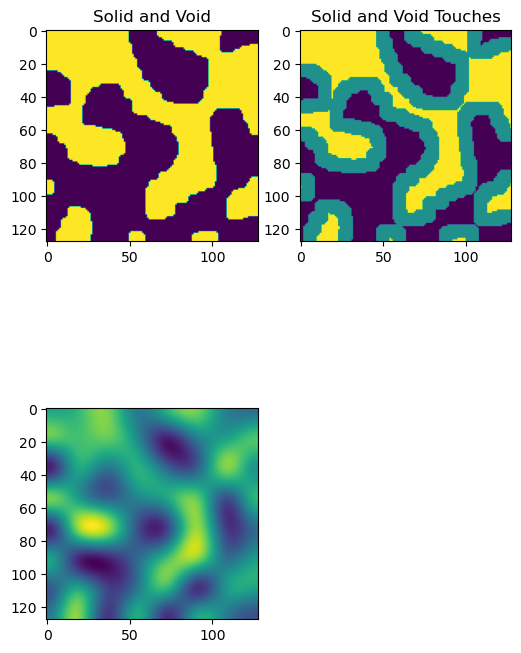

In [80]:
times = generate()

In [52]:
128**2

16384

In [81]:
times["update"]+times["select"]

5.815095999999784

No tracking: 6.94s

With tracking: 6.09s